In [1]:
import numpy as np
import sys
import matplotlib.pyplot
import warnings
import cv2
import os
from openpyxl import load_workbook

from VirusDetectAlgo import *

#PATH = 'mesurement_data_at_mizuho_20190403'
#PATH = 'mesurement_data_at_mizuho_20190423'
#PATH = 'Mizuho_Feedback_Samples_0701'
#reflection_time_para_map = {'FluA':5, 'FluB':5, 'Myco':15, 'RSV-hMPV':10, 'StrepA':5}
#min_verify_concentration_para_map = {'FluA':'1600', 'FluB':'800', 'Myco':'800', 'RSV-hMPV':'0_200', 'StrepA':'1600'}

#for factory dataset
ANALYSIS_MODE = True
PATH = 'Mizuho_only_golden_1023'
reflection_time_para_map = {'FluA':0, 'FluB':0, 'Myco':0, 'RSV-hMPV':0, 'StrepA':0}
min_verify_concentration_para_map = {'FluA':'2', 'FluB':'2', 'Myco':'2', 'RSV-hMPV':'2_2', 'StrepA':'2'}

FLAG_USE_GAMMA_ENHANCE = True
FLAG_USE_WHITE_BALANCE = False
FLAG_USE_FILTER = True
FLAG_USE_PEAK_DETECTION = True
FLAG_SHOW_FIGURE = False

if FLAG_USE_WHITE_BALANCE:
    write_table = 'White Balance'
    smoothing_value = 3
else:
    write_table = 'No White Balance'
    smoothing_value = 5
    
#for 4 Block parameter
FLAG_USE_4BLOCK = False
FLAG_NUM_POSITIVE = 4
FLAG_STD_RATE = 2

SHOW_PICTURES = 20
Control_line_rate = 0.6

CURRENT_DISEASE = ['FluA', 'FluB', 'Myco', 'RSV-hMPV', 'StrepA']
disease_chosen = CURRENT_DISEASE[3]

PATH_neg = os.path.join(PATH, disease_chosen, '0')
tags = [disease_chosen+'_Neg', disease_chosen]

all_pos_files = []
c_folder = os.listdir(os.path.join(PATH, disease_chosen))
max_constraction = int(min_verify_concentration_para_map[disease_chosen])
for c in c_folder:
    if int(c)!=0 and int(c)<= max_constraction:
        PATH_pos = os.path.join(PATH, disease_chosen, c)
        if os.path.isdir(PATH_pos):
            files = os.listdir(PATH_pos)

            for f in files:
                if f.split('.')[-1]=='bmp':
                    all_pos_files.append(os.path.join(PATH_pos, f))

all_neg_files = []
if os.path.isdir(PATH_neg):
    files_neg = os.listdir(PATH_neg)        
    for f in files_neg:
        if f.split('.')[-1]=='bmp':
            all_neg_files.append(os.path.join(PATH_neg, f))

print('pos file len = ', len(all_pos_files))
print('neg file len = ', len(all_neg_files))

def openImg(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

pos file len =  24
neg file len =  12


In [2]:
wb = load_workbook('data_analysis.xlsx')
ws = wb[write_table]

for i in range(5):
    if i==2:
        continue
    disease_chosen = CURRENT_DISEASE[i]

    PATH_neg = os.path.join(PATH, disease_chosen, '0')
    tags = [disease_chosen+'_Neg', disease_chosen]

    all_pos_files = []
    c_folder = os.listdir(os.path.join(PATH, disease_chosen))
    max_constraction = int(min_verify_concentration_para_map[disease_chosen])
    for c in c_folder:
        if int(c)!=0 and int(c)<= max_constraction:
            PATH_pos = os.path.join(PATH, disease_chosen, c)
            if os.path.isdir(PATH_pos):
                files = os.listdir(PATH_pos)

                for f in files:
                    if f.split('.')[-1]=='bmp':
                        all_pos_files.append(os.path.join(PATH_pos, f))

    all_neg_files = []
    if os.path.isdir(PATH_neg):
        files_neg = os.listdir(PATH_neg)        
        for f in files_neg:
            if f.split('.')[-1]=='bmp':
                all_neg_files.append(os.path.join(PATH_neg, f))

    print('pos file len = ', len(all_pos_files))
    print('neg file len = ', len(all_neg_files))

    if disease_chosen=='FluA':
        dn = 'C'
        dp = 'J'
        dpw = 'Q'
    elif disease_chosen=='FluB':
        dn = 'D'
        dp = 'K'
        dpw = 'R'
    elif disease_chosen=='RSV-hMPV':
        dn = 'E'
        dp = 'L'
        dpw = 'S'
        dn2 = 'F'
        dp2 = 'M'
        dpw2 = 'T'
    elif disease_chosen=='StrepA':
        dn = 'G'
        dp = 'N'
        dpw = 'U'

    gt1 = []
    pred1 = []
    gt2 = []
    pred2 = []
    line_parameters = get_line_para_map(disease_chosen)
    if len(all_neg_files)!=0:
        pos_control = []
        pos_list1 = []
        pos_list2 = []
        reflection_time = reflection_time_para_map[disease_chosen]
        for pos_i in all_neg_files:
            if reflection_time==0:
                im_p = openImg(pos_i)
                control, test_result1, test_result2 = algorithm3_with_slope(im_p, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE)
                pos_control.append(control[1])
                if control[0]==1:
                    print('pos 1 name = ', pos_i)
                    pos_list1.append(test_result1[1])
                    gt1.append(1)
                    pred1.append(int(test_result1[0]))
                    if test_result2!=None:
                        print('pos 2 name = ', pos_i)
                        pos_list2.append(test_result2[1])         
                        gt2.append(1)
                        pred2.append(int(test_result2[0]))      
        print('neg_list1 = ', pos_list1)
        for index, i in enumerate(pos_list1):
            ws[dn+ str(3+index)] = i

        if test_result2!=None:
            print('neg_list2 = ', pos_list2)
            for index, i in enumerate(pos_list2):
                ws[dn2+ str(3+index)] = i      

    if len(all_pos_files)!=0:
        pos_control = []
        pos_list1 = []
        pos_list2 = []
        reflection_time = reflection_time_para_map[disease_chosen]
        for pos_i in all_pos_files:
            if reflection_time==0:
                im_p = openImg(pos_i)
                control, test_result1, test_result2 = algorithm3_with_slope(im_p, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE)
                pos_control.append(control[1])
                if control[0]==1:
                    print('pos 1 name = ', pos_i)
                    pos_list1.append(test_result1[1])
                    gt1.append(1)
                    pred1.append(int(test_result1[0]))
                    if test_result2!=None:
                        print('pos 2 name = ', pos_i)
                        pos_list2.append(test_result2[1])         
                        gt2.append(1)
                        pred2.append(int(test_result2[0]))      
        print('pos_list1 = ', pos_list1)
        for index in range(12):
            ws[dp+ str(3+index)] = pos_list1[index]
            ws[dpw+ str(3+index)] = pos_list1[12+index]
        if test_result2!=None:
            print('pos_list2 = ', pos_list2)
            for index in range(12):
                ws[dp2+ str(3+index)] = pos_list2[index]
                ws[dpw2+ str(3+index)] = pos_list2[12+index]         

    wb.save('data_analysis.xlsx')        

pos file len =  24
neg file len =  12
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B3-OUT-FluA_Negative_RE.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B3-OUT-FluA_Negative_RE_2.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B3-OUT-FluA_Negative_RE_3.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B4-OUT-FluA_Negative.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B4-OUT-FluA_Negative_2.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B4-OUT-FluA_Negative_3.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B5-OUT-FluA_Negative.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B5-OUT-FluA_Negative_2.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B5-OUT-FluA_Negative_3.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B6-OUT-FluA_Negative.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B6-OUT-FluA_Negative_2.bmp
pos 1 name =  Mizuho_only_golden_1023\FluA\0\M05-B6-OUT-FluA_Negative_3.bmp
neg_list1 =  [3.84, 3.865, 3.72, 3.275, 3.275, 3.

pos 1 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE.bmp
pos 2 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE.bmp
pos 1 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE_2.bmp
pos 2 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE_2.bmp
pos 1 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE_3.bmp
pos 2 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE_3.bmp
pos 1 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive.bmp
pos 2 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive.bmp
pos 1 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive_2.bmp
pos 2 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive_2.bmp
pos 1 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive_3.bmp
pos 2 name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive_3.bmp
pos 1 name =  Mizu

In [ ]:
#Test for useFliter

avg_control_threshold = []    
dif_value_array1 = []
dif_value_array2 = []
line_parameters = get_line_para_map(disease_chosen)

gt1 = []
pred1 = []
gt2 = []
pred2 = []

if len(all_neg_files)!=0:
    #calcul P/N first
    if FLAG_USE_4BLOCK:
        pn1, pn2 = calculateCutOffValue4Block(all_neg_files, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_STD_RATE)
    else:
        pn1, pn2 = calculateCutOffValue(all_neg_files, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value)
    
    #for confusion martix
    for neg_i in all_neg_files:
        im_n = openImg(neg_i)
        if FLAG_USE_4BLOCK:
            control, test_result1, test_result2, test_result1_pred, test_result2_pred = algorithm3_with_slope_4block(im_n, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE, FLAG_NUM_POSITIVE)
            if control[0]==1:
                gt1.append(0)
                pred1.append(test_result1_pred)
                if test_result2!=None:
                    gt2.append(0)
                    pred2.append(test_result2_pred)
        else:            
            control, test_result1, test_result2 = algorithm3_with_slope(im_n, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE)
            if control[0]==1:
                gt1.append(0)
                pred1.append(test_result1[0])
                if test_result2!=None:
                    gt2.append(0)
                    pred2.append(test_result2[0])
else:
    pn1 = line_parameters[1][4]
    if len(line_parameters)==3:
        pn2 = line_parameters[2][4]

print('pn1 = ', pn1, 'pn2 = ', pn2)

if len(all_pos_files)!=0:
    pos_control = []
    pos_list1 = []
    pos_list2 = []
    reflection_time = reflection_time_para_map[disease_chosen]
    for pos_i in all_pos_files:
        if reflection_time==0:
            im_p = openImg(pos_i)
            print('pos 1 name = ', pos_i)
            if FLAG_USE_4BLOCK:
                control, test_result1, test_result2, test_result1_pred, test_result2_pred = algorithm3_with_slope_4block(im_p, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE, FLAG_NUM_POSITIVE)
                pos_control.append(control[1])
                if control[0]==1:        
                    pos_list1.append(test_result1[0][1])
                    gt1.append(1)
                    pred1.append(int(test_result1[0][0]))              
                    if test_result2!=None:
                        pos_list2.append(test_result2[0][1])         
                        gt2.append(1)
                        pred2.append(int(test_result2[0][0]))
            else:                
                control, test_result1, test_result2 = algorithm3_with_slope(im_p, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE)
                pos_control.append(control[1])
                if control[0]==1:
                    pos_list1.append(test_result1[1])
                    gt1.append(1)
                    pred1.append(int(test_result1[0]))
                    if test_result2!=None:
                        pos_list2.append(test_result2[1])         
                        gt2.append(1)
                        pred2.append(int(test_result2[0]))                
        else:        
            #find the ref time
            refect_time = pos_i.split('/')[-1].split('_')[-1].split('.')[0]

            time_index = refect_time.find('min')
            if time_index!=-1:
                c_ref_time_int = int(refect_time[:time_index])
                if c_ref_time_int>=reflection_time:
                    im_p = openImg(pos_i)
                    if FLAG_USE_4BLOCK:
                        control, test_result1, test_result2, test_result1_pred, test_result2_pred = algorithm3_with_slope_4block(im_p, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE, FLAG_NUM_POSITIVE)
                        pos_control.append(control[1])
                        if control[0]==1:        
                            pos_list1.append(test_result1[0][1])
                            gt1.append(1)
                            pred1.append(test_result1_pred)              
                            if test_result2!=None:
                                pos_list2.append(test_result2[0][1])         
                                gt2.append(1)
                                pred2.append(test_result2_pred)
                    else:
                        control, test_result1, test_result2 = algorithm3_with_slope(im_p, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE)
                        pos_control.append(control[1])
                        if control[0]==1:
                            pos_list1.append(test_result1[1])
                            gt1.append(1)
                            pred1.append(int(test_result1[0]))
                            if test_result2!=None:
                                pos_list2.append(test_result2[1])         
                                gt2.append(1)
                                pred2.append(int(test_result2[0]))
                        
    avg_control = np.average(pos_control)
    avg_control_th = avg_control*Control_line_rate
    print('avg_control = ', avg_control, ' control threshold = ', avg_control_th)
    avg_control_threshold.append(avg_control_th)
            
    print('')
    avg_pos_value = np.average(pos_list1)
    diff_avg = avg_pos_value - pn1
    dif_value_array1.append(diff_avg)
    print('pos_list1 = ', pos_list1)
    print('avg_pos_value1 = ', avg_pos_value)
    print('diff_avg1 = ', diff_avg)
    print('gt1 = ', gt1)
    print('pred1 = ', pred1)
                
    accuracy, sensitivity, specificity, confusion = evaluate(pred1, gt1, tags)
    print('accuracy = ', accuracy, ' sensitivity = ', sensitivity, ' specificity ', specificity)
    print("rows are predicted classes, columns are actual classes")
    for predicted_index, predicted_tag in enumerate(tags):
        print(predicted_tag,end='')
        for actual_index, actual_tag in enumerate(tags):
            print("\t%d" % confusion[predicted_index, actual_index],end='')
        print()
    print()
    if test_result2!=None:
        avg_pos_value = np.average(pos_list2)
        diff_avg = avg_pos_value - pn2
        dif_value_array2.append(diff_avg)
        print('pos_list2 = ', pos_list2)
        print('avg_pos_value2 = ', avg_pos_value)
        print('diff_avg2 = ', diff_avg)
        print('gt2 = ', gt2)
        print('pred2 = ', pred2)
        accuracy, sensitivity, specificity, confusion = evaluate(pred2, gt2, tags)
        print('accuracy = ', accuracy, ' sensitivity = ', sensitivity, ' specificity ', specificity)
        print("rows are predicted classes, columns are actual classes")
        for predicted_index, predicted_tag in enumerate(tags):
            print(predicted_tag,end='')
            for actual_index, actual_tag in enumerate(tags):
                print("\t%d" % confusion[predicted_index, actual_index],end='')
            print()
print('dif RGB testing result for control = ', avg_control_threshold)
print('dif RGB testing result for disease 1 = ', dif_value_array1)
if len(line_parameters)==3:
    print('dif RGB testing result for disease 2 = ', dif_value_array2)

Positive Sample
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE.bmp
ori img


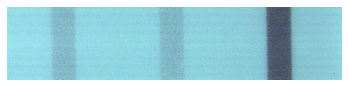

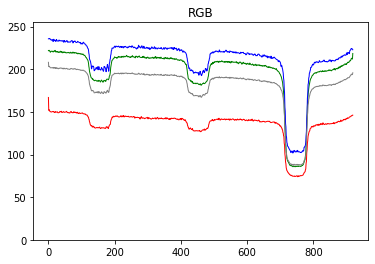

gamma enhance img


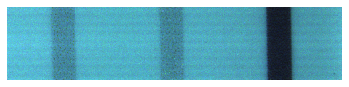

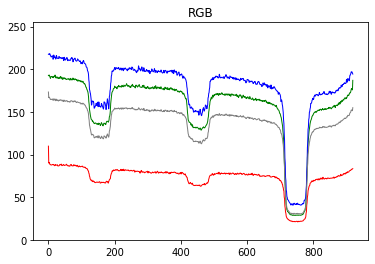

white balance img


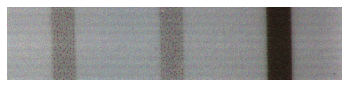

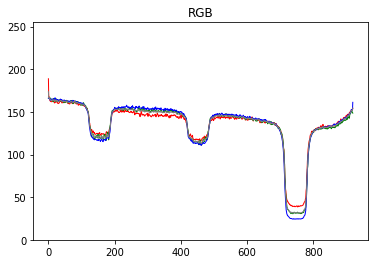

line_parameters =  [[2, 600, 800, 20, 40], [1, 50, 250, 20, 10.211], [2, 330, 530, 20, 7.261]]
test_result1 =  [1, 76.44, 80, 39.9, 152, -36.53999999999999]
test_result2 =  [1, 62.87, 100, 31.574999999999996, 166, -31.295]
 
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE_2.bmp
ori img


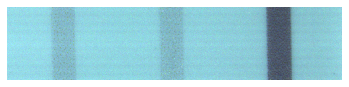

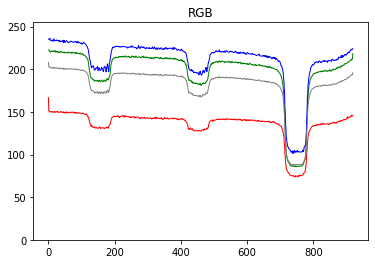

gamma enhance img


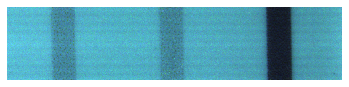

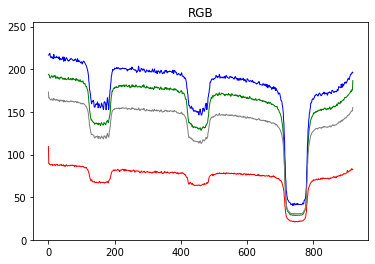

white balance img


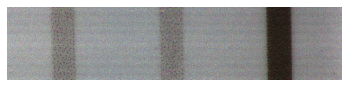

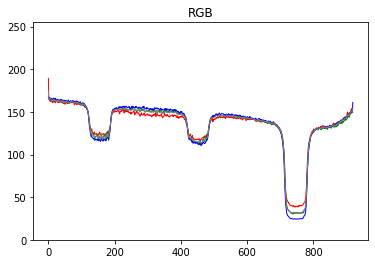

line_parameters =  [[2, 600, 800, 20, 40], [1, 50, 250, 20, 10.211], [2, 330, 530, 20, 7.261]]
test_result1 =  [1, 77.605, 80, 39.425, 152, -38.18000000000001]
test_result2 =  [1, 62.795, 98, 31.880000000000003, 162, -30.914999999999992]
 
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B3-OUT-RSV_Positive_RE_3.bmp
ori img


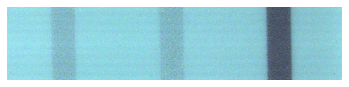

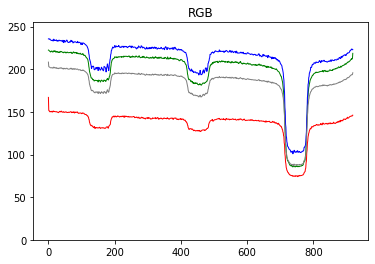

gamma enhance img


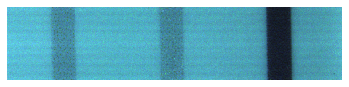

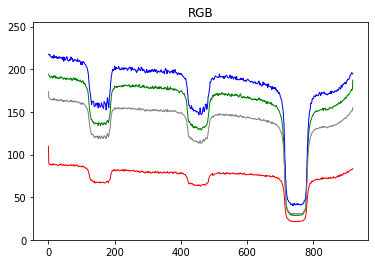

white balance img


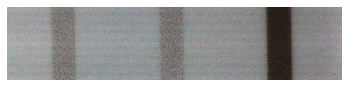

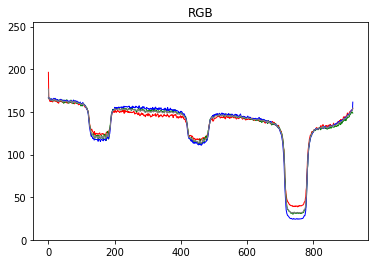

line_parameters =  [[2, 600, 800, 20, 40], [1, 50, 250, 20, 10.211], [2, 330, 530, 20, 7.261]]
test_result1 =  [1, 76.62, 80, 38.75000000000001, 144, -37.870000000000005]
test_result2 =  [1, 63.69, 100, 32.62499999999999, 166, -31.065000000000005]
 
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive.bmp
ori img


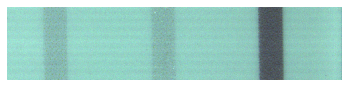

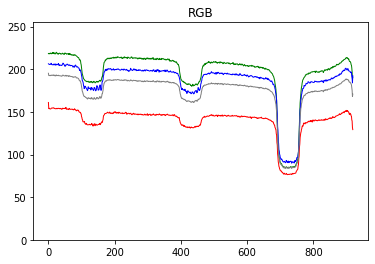

gamma enhance img


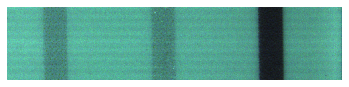

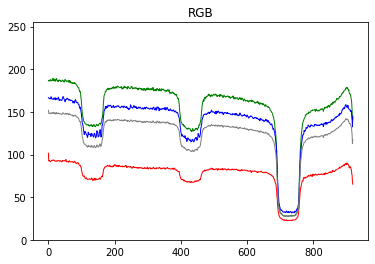

white balance img


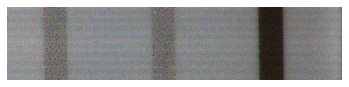

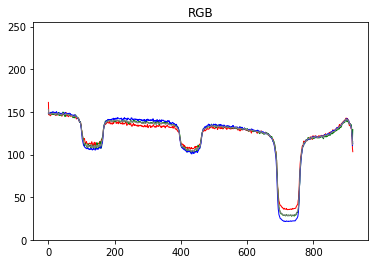

line_parameters =  [[2, 600, 800, 20, 40], [1, 50, 250, 20, 10.211], [2, 330, 530, 20, 7.261]]
test_result1 =  [1, 71.885, 58, 36.78000000000001, 130, -35.105]
test_result2 =  [1, 59.285, 76, 30.0, 142, -29.285000000000004]
 
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive_2.bmp
ori img


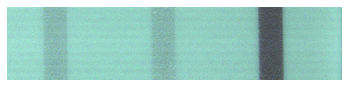

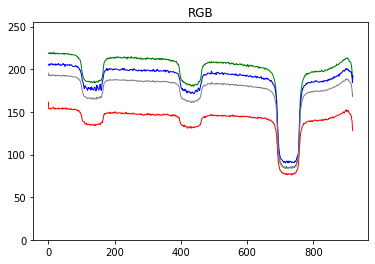

gamma enhance img


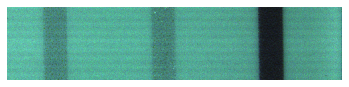

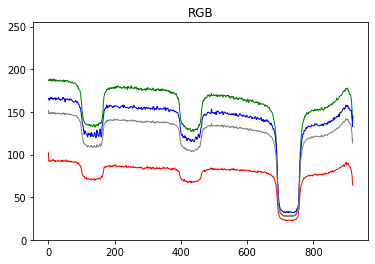

white balance img


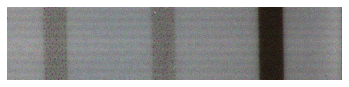

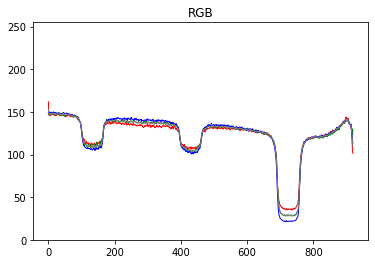

line_parameters =  [[2, 600, 800, 20, 40], [1, 50, 250, 20, 10.211], [2, 330, 530, 20, 7.261]]
test_result1 =  [1, 71.885, 58, 37.495, 130, -34.39]
test_result2 =  [1, 58.435, 76, 30.049999999999997, 140, -28.384999999999998]
 
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B4-OUT-RSV_Positive_3.bmp
ori img


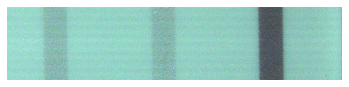

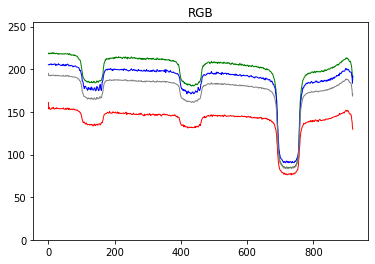

gamma enhance img


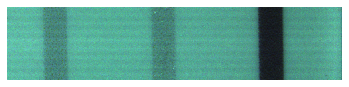

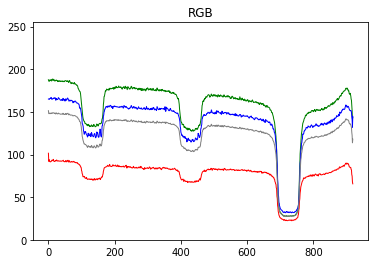

white balance img


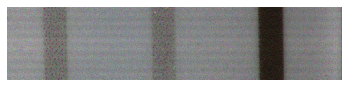

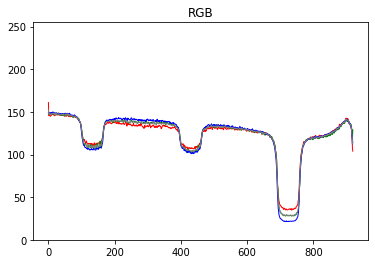

line_parameters =  [[2, 600, 800, 20, 40], [1, 50, 250, 20, 10.211], [2, 330, 530, 20, 7.261]]
test_result1 =  [1, 70.315, 58, 35.519999999999996, 130, -34.794999999999995]
test_result2 =  [1, 58.5, 74, 30.195, 140, -28.305000000000007]
 
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B5-OUT-RSV_Positive.bmp
ori img


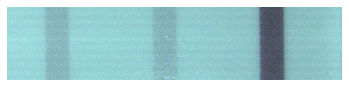

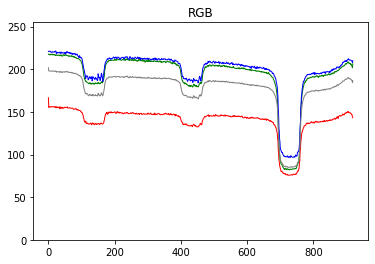

gamma enhance img


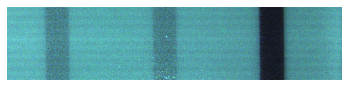

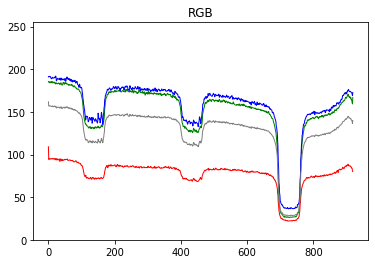

white balance img


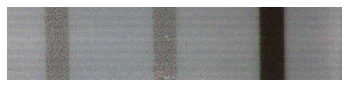

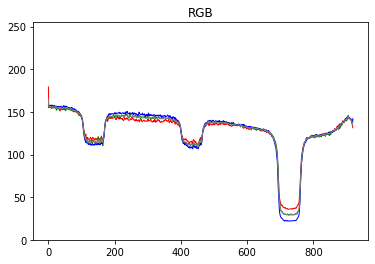

line_parameters =  [[2, 600, 800, 20, 40], [1, 50, 250, 20, 10.211], [2, 330, 530, 20, 7.261]]
test_result1 =  [1, 75.25, 70, 36.824999999999996, 134, -38.425]
test_result2 =  [1, 61.795, 82, 31.070000000000007, 143, -30.725]
 
data name =  Mizuho_only_golden_1023\RSV-hMPV\1_1\M05-B5-OUT-RSV_Positive_2.bmp
ori img


KeyboardInterrupt: 

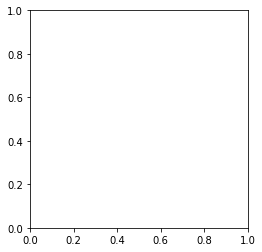

In [2]:
#show the incorrect image 
diff_case = []
print('Positive Sample')
for index, a in enumerate(all_pos_files):
    print('data name = ', a)
    print('ori img')
    im_o = openImg(a)
    show_plot(im_o)
    print('gamma enhance img')
    im_o = gamma_enhance(im_o)
    show_plot(im_o)
    print('white balance img')
    im_o = white_balance(im_o)
    show_plot(im_o)
    
    im = openImg(a)
    line_parameters = get_line_para_map(disease_chosen)
    print('line_parameters = ', line_parameters)
    control, test_result1, test_result2 = algorithm3_with_slope(im, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE)
    print('test_result1 = ', test_result1[0:-1])    
    if test_result2!=None:
        no_peak_detect = test_result2[1]
        print('test_result2 = ', test_result2[0:-1]) 
    print(' ')

print('Negative Sample')    
for index, a in enumerate(all_neg_files):
    print('data name = ', a)
    print('ori img')
    im_o = openImg(a)
    show_plot(im_o)
    print('gamma enhance img')
    im_o = gamma_enhance(im_o)
    show_plot(im_o)
    print('white balance img')
    im_o = white_balance(im_o)
    show_plot(im_o)
    
    im = openImg(a)
    line_parameters = get_line_para_map(disease_chosen)
    print('line_parameters = ', line_parameters)
    control, test_result1, test_result2 = algorithm3_with_slope(im, line_parameters, FLAG_USE_GAMMA_ENHANCE, FLAG_USE_WHITE_BALANCE, FLAG_USE_FILTER, smoothing_value, FLAG_USE_PEAK_DETECTION, FLAG_SHOW_FIGURE)
    print('test_result1 = ', test_result1[0:-1])   
    if test_result2!=None:
        no_peak_detect = test_result2[1]
        print('test_result2 = ', test_result2[0:-1])   
    print(' ')    
print('diff_case ', diff_case)    

In [ ]:
np.average(im[:, :, :]), axis=2)